In [1]:
using CairoMakie
using DelimitedFiles
using CubicSplines
using MicroMagnetic

In this example, we will compute the energy barrier of a skyrmion collapse into the ferromagnetic state using the NEB method.
Firstly, we use create_sim method to describe the studied system. For example, the system is a thin film (120x120x2 nm^3)
with periodic boundary conditions, and three energies are considered.

In [2]:
mesh = FDMesh(nx=60, ny=60, nz=1, dx=2e-9, dy=2e-9, dz=2e-9, pbc="xy")
params = Dict(
    :Ms => 3.84e5,
    :A => 3.25e-12,
    :D => 5.83e-4,
    :H => (0, 0, 120 * mT)
)

Dict{Symbol, Any} with 4 entries:
  :A  => 3.25e-12
  :H  => (0, 0, 95493.0)
  :D  => 0.000583
  :Ms => 384000.0

Using NEB can be divided into two stages. The first stage is to prepare the initial state and the final state. We assume that
the initial state is a magnetic skyrmion and the final state is ferromagnetic state.

In this method, we will obtain a magnetic skyrmion. The skyrmion state is saved as 'skx.vts'.

In [3]:
function relax_skx()
    function m0_fun_skx(i, j, k, dx, dy, dz)
        r2 = (i - 30)^2 + (j - 30)^2
        if r2 < 10^2
            return (0.01, 0, -1)
        end
        return (0, 0, 1)
    end

    sim = create_sim(mesh; m0=m0_fun_skx, params...)
    relax(sim; maxsteps=2000, stopping_dmdt=0.01)
    save_vtk(sim, "skx")

    return plot_m(sim)
end

relax_skx (generic function with 1 method)

We will invoke the relax_skx method to obtain a magnetic skyrmion state and plot the magnetization.

[ Info: MicroSim has been created.
[ Info: Exchange has been added.
[ Info: Bulk DMI has been added.
[ Info: Static Zeeman has been added.
[ Info: Running Driver : MicroMagnetic.EnergyMinimization{Float64}.
[ Info: step =    0  step_size=9.049774e-16  max_dmdt=1.112722e+04
[ Info: step =    1  step_size=2.042164e-12  max_dmdt=1.092194e+04
[ Info: step =    2  step_size=5.766994e-13  max_dmdt=2.521828e+04
[ Info: step =    3  step_size=5.309641e-12  max_dmdt=1.741307e+04
[ Info: step =    4  step_size=1.092790e-12  max_dmdt=6.458442e+04
[ Info: step =    5  step_size=6.678002e-13  max_dmdt=4.755981e+04
[ Info: step =    6  step_size=3.897512e-13  max_dmdt=3.990784e+04
[ Info: step =    7  step_size=3.799675e-13  max_dmdt=7.023159e+03
[ Info: step =    8  step_size=4.307749e-13  max_dmdt=4.669965e+03
[ Info: step =    9  step_size=5.976828e-12  max_dmdt=4.163099e+03
[ Info: step =   10  step_size=3.030012e-12  max_dmdt=7.248001e+03
[ Info: step =   11  step_size=1.490474e-12  max_dmdt=1.

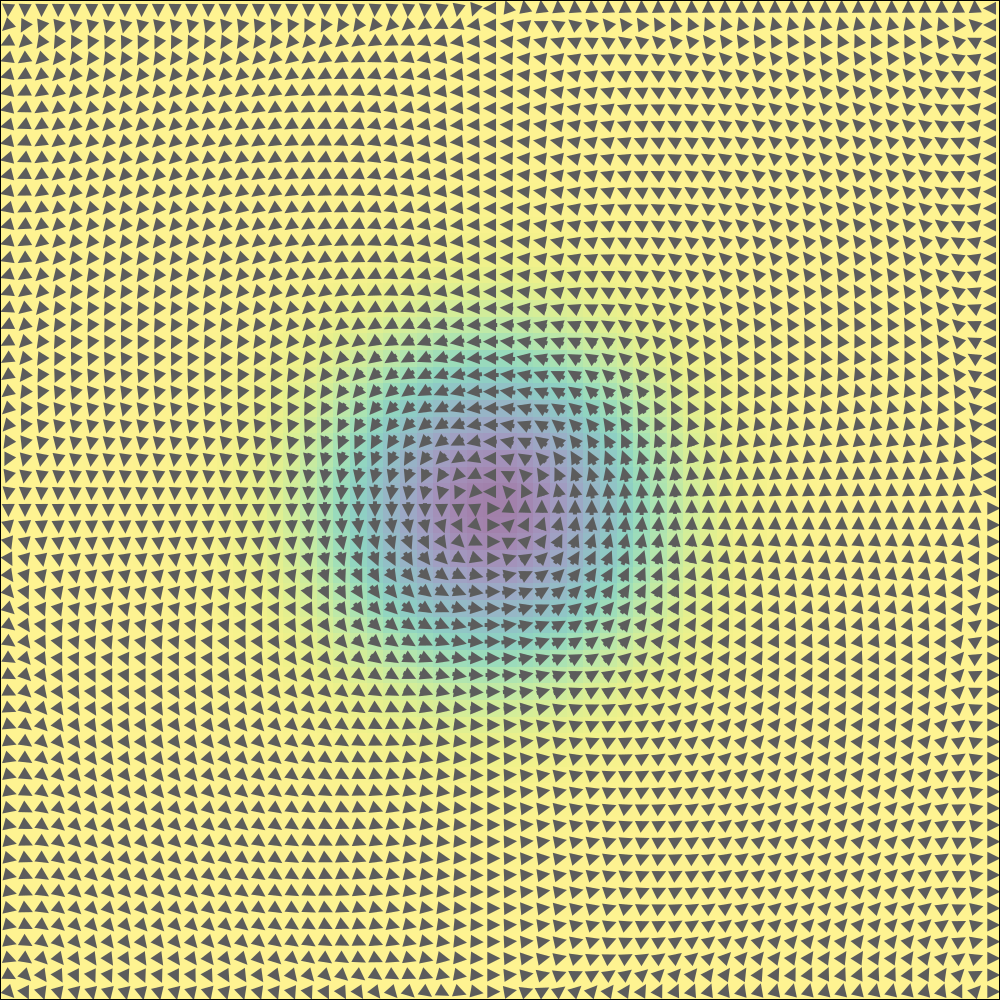

In [4]:
relax_skx()

The following is the second stage.

We need to define the initial and final state, which is stored in the init\_images list.
Note that any acceptable object, such as a function, a tuple, or an array, can be used.
Moreover, the init\_images list could contain the intermediate state if you have one.

In [5]:
init_images = [read_vtk("skx.vts"), (0, 0, 1)];

We need an interpolation array to specify how many images will be used in the NEB simulation.
Note the length of the interpolation array is the length of init\_images minus one. For example,
if init\_images = [read_vtk("skx.vts"), read_vtk("skx2.vts"), (0, 0, 1)], the length of interpolation should be 2,
i.e., something like interpolation = [5,5].

In [6]:
interpolation = [6];

To use the NEB, we use the create_sim method to create a Sim instance.

In [7]:
sim = create_sim(mesh; params...);

[ Info: MicroSim has been created.
[ Info: Exchange has been added.
[ Info: Bulk DMI has been added.
[ Info: Static Zeeman has been added.


We create the NEB instance and set the spring_constant, the driver could be "SD" or "LLG"

In [8]:
neb = NEB(sim, init_images, interpolation; name="skx_fm", driver="SD");

neb.spring_constant = 1e7

Relax the whole system

In [9]:
relax(neb; stopping_dmdt=0.1, save_vtk_every=1000, maxsteps=5000)

[ Info: Running Driver : MicroMagnetic.EnergyMinimization{Float64}.
[ Info: step =    0  step_size=9.049774e-16  max_dmdt=4.099193e+04
[ Info: step =    1  step_size=1.329080e-12  max_dmdt=3.700535e+04
[ Info: step =    2  step_size=5.936955e-13  max_dmdt=3.709928e+04
[ Info: step =    3  step_size=5.111950e-13  max_dmdt=1.485783e+04
[ Info: step =    4  step_size=3.925834e-13  max_dmdt=1.012748e+04
[ Info: step =    5  step_size=1.570271e-12  max_dmdt=8.310125e+03
[ Info: step =    6  step_size=2.019970e-12  max_dmdt=5.657644e+03
[ Info: step =    7  step_size=3.116170e-12  max_dmdt=5.329243e+03
[ Info: step =    8  step_size=3.549052e-13  max_dmdt=3.942310e+04
[ Info: step =    9  step_size=3.525064e-13  max_dmdt=4.789110e+03
[ Info: step =   10  step_size=4.221884e-13  max_dmdt=1.776622e+03
[ Info: step =   11  step_size=5.167675e-12  max_dmdt=7.198704e+02
[ Info: step =   12  step_size=3.240469e-12  max_dmdt=4.149923e+03
[ Info: step =   13  step_size=1.193528e-12  max_dmdt=1.57099

After running the simulation, the energy text file ('skx_fm_energy.txt') and the corresponding
distance text file ('skx_fm_distance.txt') are generated.

We define a function to extract the data for plotting.

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/rEu75/src/scenes.jl:227


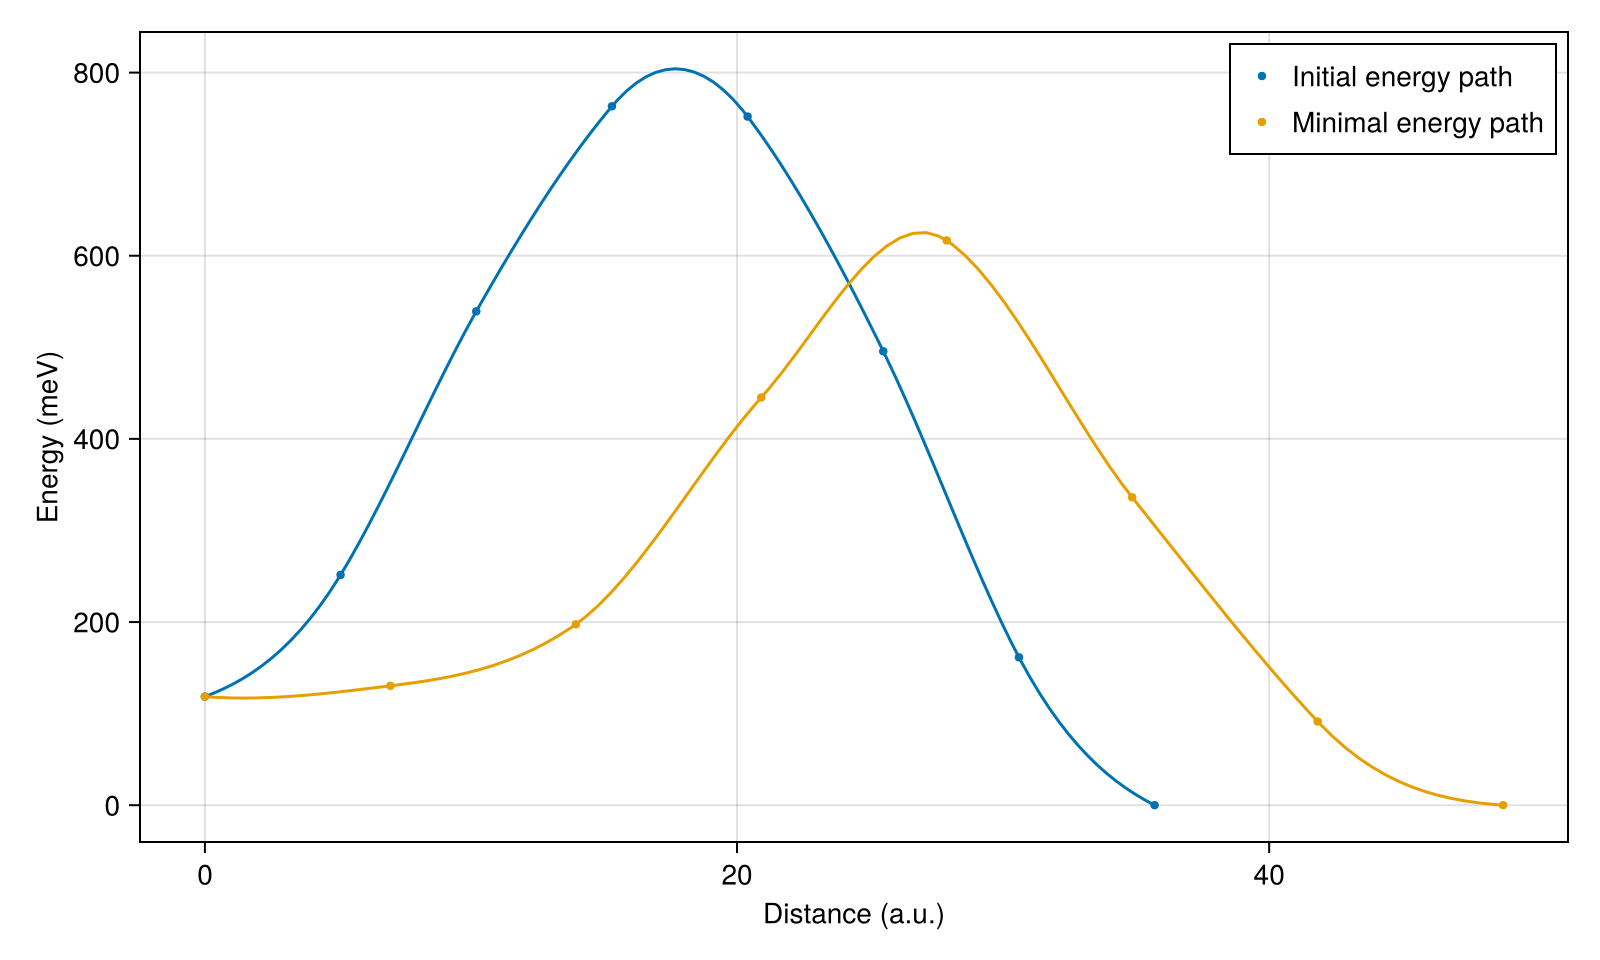

In [10]:
function extract_data(; id=1)
    energy = readdlm("assets/skx_fm_energy.txt"; skipstart=2)
    dms = readdlm("assets/skx_fm_distance.txt"; skipstart=2)
    xs = zeros(length(dms[1, 1:end]))
    for i in 2:length(xs)
        xs[i] = sum(dms[id, 2:i])
    end

    et = energy[id, 2:end]
    e0 = minimum(et)
    energy_eV = (et .- e0) / meV

    spline = CubicSpline(xs, energy_eV)

    xs2 = range(xs[1], xs[end], 100)
    energy2 = spline[xs2]

    return xs, energy_eV, xs2, energy2
end

function plot_energy()
    fig = Figure(; resolution=(800, 480))
    ax = Axis(fig[1, 1]; xlabel="Distance (a.u.)", ylabel="Energy (meV)")

    xs, energy, xs2, energy2 = extract_data(; id=1)
    scatter!(ax, xs, energy; markersize=6, label="Initial energy path")
    lines!(ax, xs2, energy2)

    xs, energy, xs2, energy2 = extract_data(; id=500)
    scatter!(ax, xs, energy; markersize=6, label="Minimal energy path")
    lines!(ax, xs2, energy2)
    #linescatter!(ax, data[:,2]*1e9, data[:,5], markersize = 6)
    #linescatter!(ax, data[:,2]*1e9, data[:,6], markersize = 6)

    axislegend()

    save("energy.png", fig)

    return fig
end

plot_energy()

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*